In [ ]:
!pip install datasets
!pip install textstat
!pip install --upgrade datasets

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Dataset loading
from datasets import load_dataset

# Model selection
from sklearn.model_selection import train_test_split

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Utility libraries
import textstat
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.sparse import hstack, issparse
import os
import random
from scipy.sparse import csr_matrix

random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

## Data Preparation (https://huggingface.co/datasets/ehovy/race)

In [ ]:
def prepare_race():
    race_middle = load_dataset('ehovy/race', 'middle')
    race_high = load_dataset('ehovy/race', 'high')

    # Convert splits to DataFrames and add difficulty labels
    middle_df = pd.concat([pd.DataFrame(race_middle[split]) for split in ['train', 'validation', 'test']])
    middle_df["difficulty"] = "middle"

    high_df = pd.concat([pd.DataFrame(race_high[split]) for split in ['train', 'validation', 'test']])
    high_df["difficulty"] = "high"

    df = pd.concat([middle_df, high_df], ignore_index=True)
    df = df.rename(columns={"example_id": "id"})
    df = df.rename(columns={"article": "passage"})
    df = df.rename(columns={"options": "choices"})
    df = df.dropna(subset=["question", "choices", "answer", "passage"])

    return df

### Pick random question from passage to reduce data size

In [ ]:
def sample_one_question_per_article(df):
    # Group by article and sample one row per unique passage
    df_sampled = df.groupby("passage", group_keys=False).apply(lambda x: x.sample(1, random_state=42))
    return df_sampled.reset_index(drop=True)

df = prepare_race()
df = sample_one_question_per_article(df)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["difficulty"], random_state=42)
train_df

/tmp/ipython-input-15-3075971056.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby("passage", group_keys=False).apply(lambda x: x.sample(1, random_state=42))


,id,passage,answer,question,choices,difficulty
13019,high22934.txt,It's nine o'clock on a Tuesday night.You are t...,B,This passage is mostly concerned with _ .,"[why maths is difficult to do, ways of getting...",high
15657,high13130.txt,Most people think about donating blood. Howeve...,D,What do people think of blood donation reminders?,"[Disturbing., Memorable., Authentic., Acceptab...",high
1425,high14590.txt,A middle-aged man with a long beard was caught...,A,The man bought lots of honey and chocolate syr...,"[have a bath to make himself sweet, do some in...",high
13155,middle6041.txt,Jack is an English boy. He is a good student. ...,D,Linda is in _ .,"[a red dress, a red coat, a green coat, a gree...",middle
5402,high17996.txt,Computers have been used in teaching for more ...,B,The passage is mainly about_.,"[a new book, a new learning way, some American...",high
...,...,...,...,...,...,...
4638,high15734.txt,Buying a house for most of the people is a onc...,A,According to the passage _ of the buyers ...,"[80%, 60%, 56.5 %, 41.2%]",high
11482,middle4935.txt,"In Germany , more than 70% of people like read...",D,Where can they buy books?,"[bookshops, small towns., on the Internet, eve...",middle
9929,high7218.txt,I am ex-navy officer and now working as a pri...,C,Why did the author take away their toy gun?,[Because the children are too young to play wi...,high
19476,middle3023.txt,Running\nRunning is good for people with too m...,B,"While cycling in cities, you should be away fr...","[keep quiet, keep safe, ride faster, enjoy fre...",middle


In [ ]:
print(train_df["difficulty"].value_counts(normalize=True))
print(test_df["difficulty"].value_counts(normalize=True))

difficulty
high      0.744406
middle    0.255594
Name: proportion, dtype: float64
difficulty
high      0.744407
middle    0.255593
Name: proportion, dtype: float64


# Baseline

### Majority Class Baseline

In [ ]:
def majority_class_baseline(df):
    most_common = df["difficulty"].value_counts().idxmax()
    baseline_acc = df["difficulty"].value_counts().max() / len(df) * 100
    print(f"Majority Class Baseline: Always Predict '{most_common}' → Accuracy: {baseline_acc:.2f}%")

majority_class_baseline(test_df)

Majority Class Baseline: Always Predict 'high' → Accuracy: 74.44%


In [ ]:
def majority_class_macro_f1(y_true):
    most_common = y_true.value_counts().idxmax()
    y_pred = [most_common] * len(y_true)
    return most_common, f1_score(y_true, y_pred, average='macro')

most_common, macro_f1_baseline = majority_class_macro_f1(test_df["difficulty"])
print(f"Majority Class Baseline (Macro F1): Always Predict '{most_common}' → F1-score: {macro_f1_baseline:.4f}")

Majority Class Baseline (Macro F1): Always Predict 'high' → F1-score: 0.4267


#### Baseline

In [ ]:
def vectorize_data(train_df, test_df):
    # Vectorizes combined text (question + choices + passage) using TF-IDF.
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x)) + " " + train_df["passage"]
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x)) + " " + test_df["passage"]

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

    X_train = vectorizer.fit_transform(train_df["combined_text"])
    X_test = vectorizer.transform(test_df["combined_text"])

    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]

    return X_train, X_test, y_train, y_test, vectorizer


def train_baseline(X_train, X_test, y_train, y_test, vectorizer, model, model_name):
    # Trains baseline classifiers and evaluates them on both train and test sets.
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)

    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)

    print(f"\n{model_name} Performance:")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(classification_report(y_train, train_preds))

    print(f"Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, test_preds))

    return model

In [ ]:
X_train, X_test, y_train, y_test, vectorizer = vectorize_data(train_df, test_df)

models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": LinearSVC(random_state=42),
    "KNN": KNeighborsClassifier(),
}

print("\nBaseline Models for RACE (80-20 split with article):")
for model_name in models:
    train_baseline(X_train, X_test, y_train, y_test, vectorizer, models[model_name], model_name)


Baseline Models for RACE (80-20 split with article):

Logistic Regression Performance:
Train Accuracy: 0.8899
              precision    recall  f1-score   support

        high       0.96      0.88      0.92     16633
      middle       0.73      0.91      0.81      5711

    accuracy                           0.89     22344
   macro avg       0.85      0.90      0.87     22344
weighted avg       0.90      0.89      0.89     22344

Test Accuracy: 0.8450
              precision    recall  f1-score   support

        high       0.93      0.86      0.89      4159
      middle       0.66      0.82      0.73      1428

    accuracy                           0.84      5587
   macro avg       0.80      0.84      0.81      5587
weighted avg       0.86      0.84      0.85      5587


Naive Bayes Performance:
Train Accuracy: 0.8508
              precision    recall  f1-score   support

        high       0.87      0.93      0.90     16633
      middle       0.76      0.61      0.68      5711



Improving the Baseline Model
* Lowering C value in LR to fix under-regularization.

Fix overfitting for Tree Models (good for feature importance):
* max_depth=5 Limits depth prevents the tree from growing too deep and memorizing
* min_samples_leaf=10 each leaf must have at least 10 examples, reducing splits on noise
* n_estimators=100 (RF) More trees helps Random Forest generalize better by averaging

In [ ]:
X_train, X_test, y_train, y_test, vectorizer = vectorize_data(train_df, test_df)
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            ),
        "KNN": KNeighborsClassifier()
        }

print("\nImproved Baseline Models for RACE (80-20 split):")
for model_name in improved_models:
  train_baseline(X_train, X_test, y_train, y_test, vectorizer, improved_models[model_name], model_name)


Improved Baseline Models for RACE (80-20 split):

Logistic Regression Performance:
Train Accuracy: 0.8338
              precision    recall  f1-score   support

        high       0.93      0.84      0.88     16633
      middle       0.64      0.81      0.71      5711

    accuracy                           0.83     22344
   macro avg       0.78      0.82      0.80     22344
weighted avg       0.85      0.83      0.84     22344

Test Accuracy: 0.8092
              precision    recall  f1-score   support

        high       0.91      0.82      0.87      4159
      middle       0.60      0.76      0.67      1428

    accuracy                           0.81      5587
   macro avg       0.75      0.79      0.77      5587
weighted avg       0.83      0.81      0.82      5587


Naive Bayes Performance:
Train Accuracy: 0.8508
              precision    recall  f1-score   support

        high       0.87      0.93      0.90     16633
      middle       0.76      0.61      0.68      5711

    

#Extra Features

## Length-based

*   Question Length
*   Passage Length
*   Average Choice Length



In [ ]:
def count_words(text):
    # Returns the number of words in a string.
    return len(text.split()) if isinstance(text, str) else 0

def avg_choice_length(choices):
    # Returns the average number of words across all choices (list of strings).
    if isinstance(choices, list) and all(isinstance(c, str) for c in choices):
        lengths = [count_words(c) for c in choices]
        return sum(lengths) / len(lengths) if lengths else 0
    return 0

def extract_length_features(df):
    # Adds word count features for question, answer, and choices.
    df["question_length"] = df["question"].apply(count_words)
    df["passage_length"] = df["passage"].apply(count_words)
    df["avg_choice_length"] = df["choices"].apply(avg_choice_length)

    return df

## Lexical Complexity


*   Average Word Length
*   Lexical Diversity (unique words/total words)



In [ ]:
def average_word_length(text):
    # Returns the average word length in a given text.
    if isinstance(text, str):
        words = text.split()
        return sum(len(word) for word in words) / len(words) if words else 0
    return 0

def lexical_diversity(text):
    # Returns the lexical diversity (unique words / total words) in a given text.
    if isinstance(text, str):
        words = text.split()
        return len(set(words)) / len(words) if words else 0
    return 0

def extract_lexical_features(df):
    # Adds lexical complexity features like avg word length and lexical diversity.
    df["avg_word_length"] = df["question"].apply(average_word_length)
    df["lexical_diversity"] = df["question"].apply(lexical_diversity)

    return df



## Readability Features

*   Flesch Reading Ease Score
*   Flesch-Kincaid Grade Level



In [ ]:
def calculate_flesch_reading_ease(text):
    return max(textstat.flesch_reading_ease(text), 0) if isinstance(text, str) else 0

def calculate_flesch_kincaid_grade(text):
    return max(textstat.flesch_kincaid_grade(text), 0) if isinstance(text, str) else 0

def extract_readability_features(df):
    # Adds readability features to the dataframe.
    df["flesch_reading_ease"] = df["question"].apply(calculate_flesch_reading_ease)
    df["flesch_kincaid_grade"] = df["question"].apply(calculate_flesch_kincaid_grade)

    return df

## Baseline with Features

In [ ]:
def vectorize_and_add_features(train_df, test_df):
    # Vectorizes text using TF-IDF and adds additional numeric features.

    train_df = extract_length_features(train_df)
    test_df = extract_length_features(test_df)

    train_df = extract_lexical_features(train_df)
    test_df = extract_lexical_features(test_df)

    train_df = extract_readability_features(train_df)
    test_df = extract_readability_features(test_df)

    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x)) + " " + train_df["passage"]
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x)) + " " + test_df["passage"]

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    feature_cols = ["question_length", "passage_length", "avg_choice_length", "flesch_reading_ease",
                    "flesch_kincaid_grade", "avg_word_length", "lexical_diversity"]

    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_features(train_df, test_df)
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            ),
        "KNN": KNeighborsClassifier()
        }

print("\nImproved Baseline Models with features for RACE (80-20 split):")
for model_name in improved_models:
  train_baseline(X_train, X_test, y_train, y_test, vectorizer, improved_models[model_name], model_name)


Improved Baseline Models with features for RACE (80-20 split):


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Performance:
Train Accuracy: 0.8437
              precision    recall  f1-score   support

        high       0.93      0.85      0.89     16633
      middle       0.66      0.82      0.73      5711

    accuracy                           0.84     22344
   macro avg       0.79      0.84      0.81     22344
weighted avg       0.86      0.84      0.85     22344

Test Accuracy: 0.8194
              precision    recall  f1-score   support

        high       0.92      0.83      0.87      4159
      middle       0.61      0.79      0.69      1428

    accuracy                           0.82      5587
   macro avg       0.77      0.81      0.78      5587
weighted avg       0.84      0.82      0.83      5587


Naive Bayes Performance:
Train Accuracy: 0.8202
              precision    recall  f1-score   support

        high       0.90      0.85      0.88     16633
      middle       0.63      0.74      0.68      5711

    accuracy                           0.82     22344


# SHAP Values

In [ ]:
def plot_shap_summary_race(model, X_sparse, vectorizer, extra_feature_array=None, extra_feature_names=None, target_class="high", title="SHAP-Plot: RACE"):
    # Combine feature names
    tfidf_feature_names = [f'"{w}"' for w in vectorizer.get_feature_names_out()]
    if extra_feature_names:
        feature_names = tfidf_feature_names + extra_feature_names
    else:
        feature_names = tfidf_feature_names

    # Convert X to dense and combine
    X_dense = X_sparse.toarray() if issparse(X_sparse) else np.asarray(X_sparse)
    X_combined = np.hstack([X_dense, extra_feature_array]) if extra_feature_array is not None else X_dense

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_combined)

    # Get correct class index
    if isinstance(shap_values, list):
        class_idx = list(model.classes_).index(target_class)
        shap_values = shap_values[class_idx]
    elif shap_values.ndim == 3:
        class_idx = list(model.classes_).index(target_class)
        shap_values = shap_values[:, :, class_idx]

    # Plot
    shap.summary_plot(shap_values, X_combined, feature_names=feature_names, show=True)



Random Forest Performance:
Train Accuracy: 0.8872
              precision    recall  f1-score   support

        high       0.95      0.90      0.92     16633
      middle       0.74      0.86      0.80      5711

    accuracy                           0.89     22344
   macro avg       0.84      0.88      0.86     22344
weighted avg       0.90      0.89      0.89     22344

Test Accuracy: 0.8430
              precision    recall  f1-score   support

        high       0.92      0.87      0.89      4159
      middle       0.67      0.77      0.71      1428

    accuracy                           0.84      5587
   macro avg       0.79      0.82      0.80      5587
weighted avg       0.85      0.84      0.85      5587



/tmp/ipython-input-27-287866249.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_combined, feature_names=feature_names, show=True)


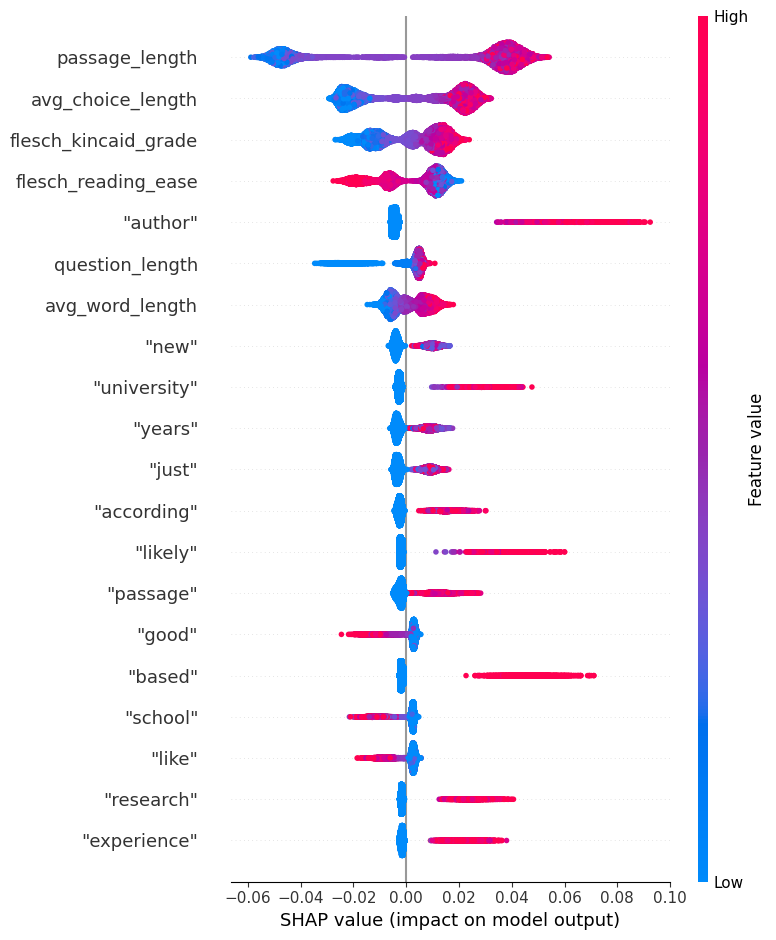

In [ ]:
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            ),
        "KNN": KNeighborsClassifier()
        }

# Vectorize data
X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_features(train_df, test_df)

# Train Random Forest
rf_model = train_baseline(
    X_train, X_test, y_train, y_test,
    vectorizer, improved_models['Random Forest'],
    'Random Forest'
)

# Extra features
extra_features = ["question_length", "passage_length", "avg_choice_length", "flesch_reading_ease", "flesch_kincaid_grade", "avg_word_length", "lexical_diversity"]

X_train = csr_matrix(X_train)
n_tfidf = len(vectorizer.get_feature_names_out())
X_tfidf = X_train[:, :n_tfidf]
X_extra = X_train[:, n_tfidf:].toarray()

plot_shap_summary_race(
    model=rf_model,
    X_sparse=X_tfidf,
    vectorizer=vectorizer,
    extra_feature_array=X_extra,
    extra_feature_names=extra_features,
    target_class="high",
    title="SHAP-Plot RACE"
)
